In [66]:
import sys
import math
from pathlib import Path

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

sys.path.append(str(Path("..").resolve()))
from data_handling import load_state_npz  # if you need it elsewhere

device = "cpu"
models_dir = Path("models")

print(f"Running on: {device}")
print(f"Looking for models in: {models_dir.resolve()}")


Running on: cpu
Looking for models in: /Users/Tonni/Desktop/master-code/neural-quantum-tomo/experiments_polish/tfim_4x4_new/models


In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import Tuple, Dict, Any


class Conditioner(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int, hidden_width: int):
        super().__init__()
        self.fc1 = nn.Linear(cond_dim, hidden_width)
        self.fc2 = nn.Linear(hidden_width, 2 * (num_visible + num_hidden))
        self.num_visible = num_visible
        self.num_hidden = num_hidden

    def forward(self, cond: torch.Tensor):
        x = torch.tanh(self.fc1(cond))
        x = self.fc2(x)
        return torch.split(
            x,
            [self.num_visible, self.num_visible, self.num_hidden, self.num_hidden],
            dim=-1
        )


class ConditionalRBM(nn.Module):
    def __init__(self, num_visible: int, num_hidden: int, cond_dim: int,
                 conditioner_width: int = 64, gibbs_k: int = 10, T: float = 1.0):
        super().__init__()
        self.num_visible = num_visible
        self.num_hidden = num_hidden
        self.gibbs_k = gibbs_k
        self.T = T

        self.W = nn.Parameter(torch.empty(num_visible, num_hidden))
        self.b = nn.Parameter(torch.zeros(num_visible))
        self.c = nn.Parameter(torch.zeros(num_hidden))
        self.conditioner = Conditioner(num_visible, num_hidden, cond_dim, conditioner_width)

    # ------------------------
    # Symmetrized scoring
    # ------------------------
    def _free_energies_pair(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor):
        v = v.to(dtype=self.W.dtype, device=self.W.device)
        v_W = v @ self.W
        W_sum = self.W.sum(dim=0)

        linear_v = v_W + c_mod
        linear_f = W_sum.unsqueeze(0) - v_W + c_mod

        term2_v = F.softplus(linear_v).sum(dim=-1)
        term2_f = F.softplus(linear_f).sum(dim=-1)

        term1_v = -(v * b_mod).sum(dim=-1)
        term1_f = -((1.0 - v) * b_mod).sum(dim=-1)

        F_v = term1_v - term2_v
        F_f = term1_f - term2_f
        return F_v, F_f

    def _free_energy(self, v: torch.Tensor, b_mod: torch.Tensor, c_mod: torch.Tensor) -> torch.Tensor:
        F_v, F_f = self._free_energies_pair(v, b_mod, c_mod)
        stacked = torch.stack([-F_v, -F_f], dim=-1)
        return -self.T * torch.logsumexp(stacked / self.T, dim=-1)

    def _compute_effective_biases(self, cond: torch.Tensor):
        gamma_b, beta_b, gamma_c, beta_c = self.conditioner(cond)
        if cond.dim() == 1:
            b_mod = (1.0 + gamma_b) * self.b + beta_b
            c_mod = (1.0 + gamma_c) * self.c + beta_c
        else:
            b_mod = (1.0 + gamma_b) * self.b.unsqueeze(0) + beta_b
            c_mod = (1.0 + gamma_c) * self.c.unsqueeze(0) + beta_c
        return b_mod, c_mod

    # ------------------------
    # Fast exact symmetrized Gibbs (no FE inside loop)
    # ------------------------
    @staticmethod
    def _apply_flip(v: torch.Tensor, s0: torch.Tensor) -> torch.Tensor:
        return s0 * v + (1.0 - s0) * (1.0 - v)  # s0=1 keep, s0=0 flip

    def _sample_s_given_v_h(self, v: torch.Tensor, a: torch.Tensor, b_mod: torch.Tensor, rng: torch.Generator):
        vb   = (v * b_mod).sum(dim=-1)
        va   = (v * a).sum(dim=-1)
        bsum = b_mod.sum(dim=-1)
        asum = a.sum(dim=-1)

        dE = (-bsum - asum + 2.0 * vb + 2.0 * va)
        p_s0 = torch.sigmoid(dE / self.T)
        return torch.bernoulli(p_s0, generator=rng).to(v.dtype).unsqueeze(-1)

    def _gibbs_step_sym_fast(
            self,
            v: torch.Tensor,
            h: torch.Tensor,
            s0: torch.Tensor,
            b_mod: torch.Tensor,
            c_mod: torch.Tensor,
            rng: torch.Generator
    ):
        if b_mod.dim() == 1:
            b_mod = b_mod.unsqueeze(0).expand(v.size(0), -1)
        if c_mod.dim() == 1:
            c_mod = c_mod.unsqueeze(0).expand(v.size(0), -1)

        # 1) h | v,s
        v_eff = self._apply_flip(v, s0)
        p_h = torch.sigmoid((v_eff @ self.W + c_mod) / self.T)
        h = torch.bernoulli(p_h, generator=rng)

        # reuse a := W h
        a = h @ self.W.t()

        # 2) s | v,h
        s0 = self._sample_s_given_v_h(v, a, b_mod, rng)

        # 3) v | h,s (sample in effective space, then unflip)
        p_v_eff = torch.sigmoid((a + b_mod) / self.T)
        v_eff = torch.bernoulli(p_v_eff, generator=rng)
        v_next = self._apply_flip(v_eff, s0)

        return v_next, h, s0

    # ------------------------
    # Public API
    # ------------------------
    def log_score(self, v: torch.Tensor, cond: torch.Tensor) -> torch.Tensor:
        b_mod, c_mod = self._compute_effective_biases(cond)
        return -0.5 * self._free_energy(v, b_mod, c_mod) / self.T

    @torch.no_grad()
    def generate(self, cond: torch.Tensor, n_samples: int, rng: torch.Generator):
        device = self.W.device
        dtype  = self.W.dtype

        cond = cond.to(device=device, dtype=dtype)
        if cond.dim() == 1:
            cond = cond.expand(n_samples, -1)

        b_mod, c_mod = self._compute_effective_biases(cond)

        # start from noise
        v = torch.bernoulli(
            torch.full((n_samples, self.num_visible), 0.5, device=device, dtype=dtype),
            generator=rng
        )

        # chain state
        h = torch.zeros((n_samples, self.num_hidden), device=device, dtype=dtype)
        s0 = torch.bernoulli(
            torch.full((n_samples, 1), 0.5, device=device, dtype=dtype),
            generator=rng
        )

        for _ in range(self.gibbs_k):
            v, h, s0 = self._gibbs_step_sym_fast(v, h, s0, b_mod, c_mod, rng)

        return v

In [81]:
def load_model():
    latest_path = Path("./models/crbm_tfim_4x4_20000_suscept_20251215_215050.pt")
    #latest_path = Path("./models/crbm_tfim_4x4_100000_suscept_20251211_165059.pt")
    #latest_path = Path("./models/crbm_tfim_4x4_50000_suscept_20251212_202305.pt")

    print(f"Loading checkpoint: {latest_path.name}")
    checkpoint = torch.load(latest_path, map_location=device)
    config = checkpoint["config"]

    model = ConditionalRBM(
        num_visible=config["num_visible"],
        num_hidden=config["num_hidden"],
        cond_dim=1,
        gibbs_k=config.get("gibbs_k", 10),
    ).to(device)

    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    return model, config

model, config = load_model()
h_support = config.get("h_support", [])
GEN_SIDE_LENGTH = int(math.sqrt(model.num_visible))

print(f"Model Loaded. System Size: {GEN_SIDE_LENGTH}x{GEN_SIDE_LENGTH}")
print(f"Support Points: {h_support}")


Loading checkpoint: crbm_tfim_4x4_20000_suscept_20251215_215050.pt
Model Loaded. System Size: 4x4
Support Points: [1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 5.0]


In [82]:
def all_binary_states(num_visible: int, device="cpu", dtype=torch.float32):
    ints = torch.arange(2**num_visible, device=device, dtype=torch.int64)
    bits = ((ints[:, None] >> torch.arange(num_visible, device=device)) & 1)
    return bits.to(dtype=dtype)

dtype = next(model.parameters()).dtype
all_v = all_binary_states(model.num_visible, device=device, dtype=dtype)
print("All configs:", all_v.shape)  # (65536, 16) for 4x4


All configs: torch.Size([65536, 16])


In [83]:
@torch.no_grad()
def rbm_state_vector_batched(model, all_v, h_val: float, batch_size: int = 8192):
    n = all_v.shape[0]
    dtype = next(model.parameters()).dtype

    # 1st pass: compute max logpsi for stability
    max_lp = -1e30
    logpsi_chunks = []
    for start in range(0, n, batch_size):
        v = all_v[start:start+batch_size]
        cond = torch.full((v.shape[0], 1), float(h_val), device=v.device, dtype=dtype)
        lp = model.log_score(v, cond)  # (batch,)
        logpsi_chunks.append(lp.cpu())
        max_lp = max(max_lp, float(lp.max().cpu()))

    # 2nd pass: exp(logpsi-max) and normalize in L2
    norm2 = 0.0
    psi_chunks = []
    for lp in logpsi_chunks:
        x = torch.exp(lp - max_lp)
        norm2 += float(torch.sum(x * x))
        psi_chunks.append(x)

    norm = math.sqrt(norm2)
    psi = torch.cat(psi_chunks, dim=0) / norm
    return psi.numpy()  # real-positive wavefunction

# choose surface grid
h_values_surf = np.linspace(1.0, 4.0, 25)


In [84]:
psis = []
for h in tqdm(h_values_surf, desc="Building RBM states"):
    psis.append(rbm_state_vector_batched(model, all_v, h, batch_size=8192))

psis = np.stack(psis, axis=0)  # (Nh, 2^N)
print("psis:", psis.shape)


Building RBM states: 100%|██████████| 25/25 [00:02<00:00,  9.94it/s]

psis: (25, 65536)


In [85]:
# overlaps S_ij = <psi_i | psi_j>
S = psis @ psis.T
F = (np.abs(S) ** 2).astype(np.float64)

logF = F #np.log(F + 1e-12)


In [86]:
import math
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm

import plotly.graph_objects as go
from pathlib import Path


def _get(npz, *keys):
    for k in keys:
        if k in npz.files:
            return npz[k]
    raise KeyError(f"None of {keys} found. Available keys: {npz.files}")


def all_binary_states(num_visible: int, device, dtype=torch.float32):
    """
    Returns all {0,1}^N configurations as (2^N, N).
    Bit-order: LSB-first (matches your original code).
    """
    ints = torch.arange(2**num_visible, device=device, dtype=torch.int64)
    bits = ((ints[:, None] >> torch.arange(num_visible, device=device)) & 1)
    return bits.to(dtype=dtype)


In [87]:
dtype = next(model.parameters()).dtype
device = next(model.parameters()).device

all_v = all_binary_states(model.num_visible, device=device, dtype=dtype)
print("All configs:", all_v.shape)  # (2^N, N) e.g. (65536, 16)


All configs: torch.Size([65536, 16])


In [88]:
@torch.no_grad()
def rbm_state_vector_batched(model, all_v, h_val: float, batch_size: int = 8192):
    """
    Computes the normalized (real, positive) state vector psi(v|h) over all_v:
      psi(v) ∝ exp(log_score(v,h))
    using a stable two-pass scheme.
    Returns numpy float64 of shape (2^N,).
    """
    n = all_v.shape[0]
    dtype = next(model.parameters()).dtype
    device = next(model.parameters()).device

    # pass 1: compute max logpsi for stability and cache chunks on CPU
    max_lp = -1e30
    logpsi_chunks = []
    for start in range(0, n, batch_size):
        v = all_v[start:start + batch_size]
        cond = torch.full((v.shape[0], 1), float(h_val), device=device, dtype=dtype)
        lp = model.log_score(v, cond)              # (batch,)
        lp_cpu = lp.detach().cpu()
        logpsi_chunks.append(lp_cpu)
        max_lp = max(max_lp, float(lp_cpu.max()))

    # pass 2: exponentiate (shifted), accumulate norm^2, then normalize
    norm2 = 0.0
    psi_chunks = []
    for lp_cpu in logpsi_chunks:
        x = torch.exp(lp_cpu - max_lp)             # CPU tensor
        norm2 += float(torch.sum(x * x))
        psi_chunks.append(x)

    psi = torch.cat(psi_chunks, dim=0).to(torch.float64)
    psi = psi / math.sqrt(norm2)
    return psi.numpy()


h_values_surf = np.linspace(1.0, 4.0, 25)

psis = []
for h in tqdm(h_values_surf, desc="Building RBM states"):
    psis.append(rbm_state_vector_batched(model, all_v, h, batch_size=8192))

psis = np.stack(psis, axis=0).astype(np.float64)  # (Nh, 2^N)
print("psis:", psis.shape)


Building RBM states: 100%|██████████| 25/25 [00:02<00:00,  9.38it/s]

psis: (25, 65536)


In [89]:
import numpy as np

D = np.load("tfim_4x4_fidelity_surface.npz")

h_file = np.asarray(D["h_values"], dtype=float)
logF_file = np.asarray(D["logF"], dtype=float)   # stored as -log(F) in your old pipeline

# convert back to fidelity
F_file =logF_file

print("keys:", D.files)
print("h_file:", h_file.shape, "logF_file:", logF_file.shape, "F_file:", F_file.shape)
print("F_file range:", float(F_file.min()), float(F_file.max()))


keys: ['h_values', 'logF']
h_file: (25,) logF_file: (25, 25) F_file: (25, 25)
F_file range: 0.029535244524806433 1.000000000000011


In [90]:
import plotly.graph_objects as go

h_mem = np.asarray(h_values_surf, dtype=float)
F_mem = np.asarray(F_mem, dtype=float)  # from your computation cell

if not (h_mem.shape == h_file.shape and np.allclose(h_mem, h_file) and F_mem.shape == F_file.shape):
    raise ValueError(
        f"Grids/shapes don't match.\n"
        f"h_mem: {h_mem.shape}, h_file: {h_file.shape}, F_mem: {F_mem.shape}, F_file: {F_file.shape}"
    )

h = h_mem
H1, H2 = np.meshgrid(h, h)

dF = F_mem - F_file
absmax = float(np.max(np.abs(dF))) + 1e-12

z_min = float(min(F_mem.min(), F_file.min()))
z_max = float(max(F_mem.max(), F_file.max()))
z_range = z_max - z_min
z_eps = 1e-3 * (z_range + 1e-12)
z_floor = z_min - 0.05 * (z_range + 1e-12)

fig = go.Figure()

fig.add_trace(go.Surface(
    x=H1, y=H2, z=F_file,
    colorscale="Viridis",
    showscale=False,
    opacity=0.90,
    name="file fidelity"
))

fig.add_trace(go.Surface(
    x=H1, y=H2, z=F_mem + z_eps,
    colorscale="Magma",
    showscale=False,
    opacity=0.55,
    name="memory fidelity"
))

fig.add_trace(go.Surface(
    x=H1, y=H2, z=np.full_like(dF, z_floor),
    surfacecolor=dF,
    colorscale="RdBu",
    cmin=-absmax, cmax=absmax,
    showscale=True,
    opacity=0.95,
    name="ΔF (mem-file)",
    colorbar=dict(title="ΔF", len=0.6)
))

fig.update_layout(
    title="TFIM 4x4 - Fidelity Surfaces + ΔF Carpet",
    margin=dict(l=0, r=0, b=0, t=40),
    scene=dict(
        xaxis_title="h",
        yaxis_title="h'",
        zaxis_title="Fidelity F(h,h')",
        zaxis=dict(range=[z_floor, z_max + 3.0 * z_eps]),
    ),
)

fig.show()


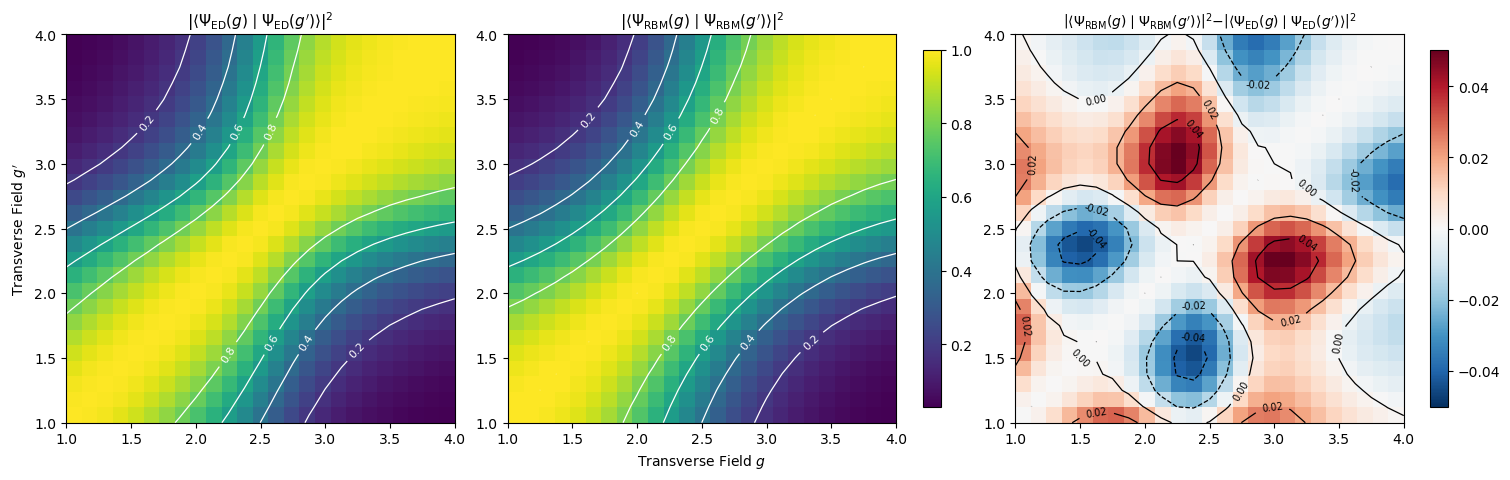

In [109]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

g = np.asarray(h_values_surf, dtype=float)
F_RBM = np.asarray(F_mem, dtype=float)
F_ED  = np.asarray(F_file, dtype=float)

if F_RBM.shape != F_ED.shape or F_RBM.shape != (g.size, g.size):
    raise ValueError(f"Shape mismatch: g {g.shape}, F_RBM {F_RBM.shape}, F_ED {F_ED.shape}")

dF = F_RBM - F_ED

Fmin = float(min(np.nanmin(F_RBM), np.nanmin(F_ED)))
Fmax = float(max(np.nanmax(F_RBM), np.nanmax(F_ED)))
absmax = float(np.nanmax(np.abs(dF))) + 1e-12

gmin, gmax = float(np.nanmin(g)), float(np.nanmax(g))
extent = [gmin, gmax, gmin, gmax]

G, Gp = np.meshgrid(g, g)

levels_F = np.arange(0.0, 1.0 + 1e-9, 0.2)

# symmetric, "even" 0.02 spacing: ..., -0.04, -0.02, 0, 0.02, 0.04, ...
step = 0.02
kmax = int(np.ceil(absmax / step))
levels_d = step * np.arange(-kmax, kmax + 1)

fig, axs = plt.subplots(1, 3, figsize=(15, 4.8), constrained_layout=True)

# --- ED (no colorbar) ---
im0 = axs[0].imshow(F_ED, origin="lower", extent=extent, vmin=Fmin, vmax=Fmax, aspect="equal")
c0 = axs[0].contour(G, Gp, F_ED, levels=levels_F, colors="white", linewidths=0.9)
axs[0].clabel(c0, inline=True, fontsize=8, fmt="%.1f", colors="white")
axs[0].set_title(r"$\left|\langle \Psi_{\mathrm{ED}}(g)\mid \Psi_{\mathrm{ED}}(g')\rangle\right|^2$", fontsize=11)
axs[0].set_xlabel("")
axs[0].set_ylabel(r"Transverse Field $g'$")

# --- RBM ---
im1 = axs[1].imshow(F_RBM, origin="lower", extent=extent, vmin=Fmin, vmax=Fmax, aspect="equal")
c1 = axs[1].contour(G, Gp, F_RBM, levels=levels_F, colors="white", linewidths=0.9)
axs[1].clabel(c1, inline=True, fontsize=8, fmt="%.1f", colors="white")
axs[1].set_title(r"$\left|\langle \Psi_{\mathrm{RBM}}(g)\mid \Psi_{\mathrm{RBM}}(g')\rangle\right|^2$", fontsize=11)
axs[1].set_xlabel(r"Transverse Field $g$")
axs[1].set_ylabel("")
plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

# --- Difference ---
norm = TwoSlopeNorm(vmin=-absmax, vcenter=0.0, vmax=absmax)
im2 = axs[2].imshow(dF, origin="lower", extent=extent, norm=norm, aspect="equal", cmap="RdBu_r")
c2 = axs[2].contour(G, Gp, dF, levels=levels_d, colors="black", linewidths=0.9)
axs[2].clabel(c2, inline=True, fontsize=7, fmt="%.2f", colors="black")
axs[2].set_title(
    r"$\left|\langle \Psi_{\mathrm{RBM}}(g)\mid \Psi_{\mathrm{RBM}}(g')\rangle\right|^2$"
    r"$-\left|\langle \Psi_{\mathrm{ED}}(g)\mid \Psi_{\mathrm{ED}}(g')\rangle\right|^2$",
    fontsize=10
)
axs[2].set_xlabel("")
axs[2].set_ylabel("")
plt.colorbar(im2, ax=axs[2], fraction=0.046, pad=0.04)

for ax in axs:
    try:
        ax.set_box_aspect(1)
    except Exception:
        ax.set_aspect("equal", adjustable="box")

plt.show()